In [1]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import json
import pandas as pd
sc = SparkContext('local', appName='Ugly')

In [2]:
sc._jsc.hadoopConfiguration().set("textinputformat.record.delimiter", "\r\n\r\n")

In [3]:
file = './amazon-meta.txt'
data = sc.textFile(file)

## Utils

Parse function transforms the textual document into a python dictionary

In [4]:
def parse(text):
    lines = text.split('\r\n')
    obj = {}
    ID = -1
    reading_categories = False
    reading_reviews = False
    for i in lines:

        if reading_categories:
            categories = i.split('|')
            if(len(categories) == 1):
                reading_categories = False
            else:
                obj['CATEGORIES']['categories'].append(categories[len(categories)-1])

        if reading_reviews:
            reviewsObj = {}
            reviewsObj['date'] = i.split(' cutomer')[0].replace(' ', '')
            reviews = i.split(': ')
            reviewsObj['customer'] = reviews[1].split(
                ' rating')[0].replace(' ', '')
            reviewsObj['rating'] = reviews[2].split(' ')[0].replace(' ', '')
            reviewsObj['votes'] = reviews[3].split(
                ' helpful')[0].replace(' ', '')
            reviewsObj['helpful'] = reviews[4].replace(' ', '')
            obj['REVIEWS']['reviews'].append(reviewsObj)

        elif 'Id:' in i:
            obj['ID'] = i.split('Id:')[1].replace(' ', '')
            ID = obj['ID']
        elif 'ASIN:' in i:
            obj['ASIN'] = i.split('ASIN:')[1].replace(' ', '')
        elif 'title:' in i:
            title = i.split('title: ')[1]
            obj['TITLE'] = title
        elif 'group:' in i:
            obj['GROUP'] = i.split('group: ')[1]
        elif 'salesrank:' in i:
            obj['SALESRANK'] = i.split('salesrank: ')[1]
        elif 'similar:' in i:
            similars = i.split(': ')[1].split('  ')
            number_of_similars = similars[0]
            similars.pop(0)
            obj['SIMILARS'] = {
                'size': number_of_similars, 'similars': similars}
        elif 'categories:' in i:
            number_of_categories = i.split(': ')[1]
            obj['CATEGORIES'] = {
                'size': number_of_categories, 'categories': []}
            reading_categories = True
        if 'reviews:' in i:
            reviews_split = i.split(': ')
            total = reviews_split[2].split('  ')[0]
            downloaded = reviews_split[3].split('  ')[0]
            avg_rating = reviews_split[4]
            obj['REVIEWS'] = {'total': total, 'downloaded': downloaded,
                            'avg_rating': avg_rating, 'reviews': []}
            reading_reviews = True
    return obj


# Doc = Text Document
def filterById(doc, selected_id):
    lines = doc.split('\n')
    for line in lines:
        if 'Id:  ' in line:
            ID = int(line.split('Id:')[1].replace(' ', ''))
            if( ID == selected_id ):
                return True
            else:
                return None

# Just to print
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## Questão A

### Dado um produto, listar:
### --- Os 5 comentários mais úteis e com a maior avaliação.
### --- Os 5 comentários mais úteis e com a menor avaliação.

In [5]:
def getReviewsByUseful(doc):
    obj = parse(doc)
    try:
        array = []
        for review in obj['REVIEWS']['reviews']:
            rev = ( review['date'], review['customer'], int(review['rating']), int(review['votes']), int(review['helpful']) )
            array.append( ( int(review['helpful']), ( int(review['rating']), rev ) ) )
        return array
    except Exception as e:
        return array

# MACRO's for 
SELECTED_ID = 2
KEY = 0
VALUE = 1
RATING = 0
REVIEW = 1

most_useful = data.filter(lambda x: filterById(x, SELECTED_ID)) \
            .flatMap(getReviewsByUseful) \
            .sortByKey(ascending = False) \
            .take(5)

rdd_most_useful = sc.parallelize(most_useful)

best_rating = rdd_most_useful.sortBy( lambda x: x[VALUE][RATING], ascending = False ) \
                              .map( lambda x: x[VALUE] ) \
                              .values() \
                              .collect()
worst_rating = rdd_most_useful.sortBy( lambda x: x[VALUE][RATING], ascending = True ) \
                              .map( lambda x: x[VALUE] ) \
                              .values() \
                              .collect()

### 5 comentários mais úteis ordenados pela MAIOR avaliação

In [6]:
df = pd.DataFrame(data=best_rating, columns=['Date', 'Customer', 'Rating', 'Votes', 'Helpful'])
df

,Date,Customer,Rating,Votes,Helpful
0,2002-1-24,A13SG9ACZ9O5IM,5,8,8
1,2002-5-23,A1GIL64QK68WKL,5,8,8
2,2002-2-6,A2P6KAWXJ16234,4,16,16
3,2002-3-23,A3GO7UV9XX14D8,4,6,6
4,2004-2-11,A1CP26N8RHYVVO,1,13,9


### 5 comentários mais úteis ordenados pela MENOR avaliação

In [7]:
df = pd.DataFrame(data=worst_rating, columns=['Date', 'Customer', 'Rating', 'Votes', 'Helpful'])
df

,Date,Customer,Rating,Votes,Helpful
0,2004-2-11,A1CP26N8RHYVVO,1,13,9
1,2002-2-6,A2P6KAWXJ16234,4,16,16
2,2002-3-23,A3GO7UV9XX14D8,4,6,6
3,2002-1-24,A13SG9ACZ9O5IM,5,8,8
4,2002-5-23,A1GIL64QK68WKL,5,8,8


## Questão B

### Dado um produto, listar os produtos similares com maiores vendas do que ele

In [8]:
SELECTED_ID = 2

# Filter the required ID
# Map emits a ( ID, Text Doc ) tuple
rdd_id = data.filter(lambda x: filterById(x, SELECTED_ID))

# Convert the Textual Document into a Dictionary to extract the SIMILARS and the SALESRANK
obj = parse(rdd_id.first())
similars = obj['SIMILARS']['similars']
minimal_salesrank = obj['SALESRANK']

# In map filter
#    Checks if ASIN is in the similar list 
#    Checks if the SALESRANK is lower than the minimal_salesrank
def filterSimilarsBySalesrank(doc, similars, minimal_salesrank):
    obj = parse(doc)
    try:
        if obj['ASIN'] in similars and obj['SALESRANK'] <= minimal_salesrank:
            return True
        else:
            return None
    except Exception as e:
        return None

# Emit: ( SALESRANK, TITLE )
def emitTitleAndSalesrank(doc):
    obj = parse(doc)
    try:
        return ( int(obj['SALESRANK']), obj['TITLE'] )
    except Exception as e:
        return ( -1, -1 )
    
# In map filter - Filter similars with smaller salesrank
rdd_b = data.filter(lambda x: filterSimilarsBySalesrank( x, similars, minimal_salesrank ) ) \
            .map( emitTitleAndSalesrank ) \
            .filter( lambda x: x[KEY] != -1 ) \
            .sortByKey(ascending=True)

answer_a = rdd_b.collect()

In [9]:
df = pd.DataFrame(data=answer_a, columns=['Salesrank', 'Title'])
df

,Salesrank,Title
0,103012,Yule: A Celebration of Light and Warmth
1,159277,Midsummer: Magical Celebrations of the Summer ...


## Questão C

### Dado um produto, mostrar a evolução diária das médias de avaliação ao longo do intervalo de tempo coberto no arquivo de entrada

In [10]:
# Um bom exemplo é o ID 19367 (vários reviews)
SELECTED_ID = 19367

def emitReviewsByDate(doc):
    obj = parse(doc)
    array = []
    try:
        avg_rating = obj['REVIEWS']['avg_rating']
        for review in obj['REVIEWS']['reviews']:
            date = datetime.datetime.strptime(review['date'], '%Y-%m-%d').date()
            rating = review['rating']
            array.append( ( date , ( float(rating), float(avg_rating), 1 ) ) )
        return array
    except Exception as e:
        return array
        
KEY = 0
VALUE = 1
RATING = 0
AVG_RATING = 1
    
    
# Filter the required ID (emits a DOC)
# Map emits a ( ID, Text Doc ) tuple
rdd_c = data.filter(lambda x: filterById(x, SELECTED_ID)) \
                .flatMap( emitReviewsByDate ) \
                .sortByKey(ascending=True)

answer_c = rdd_c.map( lambda x: ( x[KEY], x[VALUE][RATING], x[VALUE][AVG_RATING] ) ).collect()

In [11]:
# Get growth by date

## To each date, calculate the mean at the time (instant mean)
def addToAverage(old_av, value, new_size):
    new_av = float(old_av) + ( float(value) - float(old_av) ) / float(new_size)
    return new_av

counter = 0
means_array = [0]
for el in answer_c:
    means_array.append(addToAverage( means_array[ len(means_array)-1 ], el[1], len(means_array) ))
means_array.pop(0)

0

         dates  rating  avg_rating  avg_rating_growth
0   1998-09-21     5.0         4.0           5.000000
1   1998-10-15     5.0         4.0           5.000000
2   1998-10-21     5.0         4.0           5.000000
3   1998-10-23     2.0         4.0           4.250000
4   1998-11-01     5.0         4.0           4.400000
5   1998-11-02     5.0         4.0           4.500000
6   1998-11-02     5.0         4.0           4.571429
7   1998-11-02     5.0         4.0           4.625000
8   1998-11-04     5.0         4.0           4.666667
9   1998-11-10     2.0         4.0           4.400000
10  1998-11-11     5.0         4.0           4.454545
11  1998-11-24     5.0         4.0           4.500000
12  1998-11-27     2.0         4.0           4.307692
13  1998-12-01     1.0         4.0           4.071429
14  1998-12-06     4.0         4.0           4.066667
15  1998-12-11     5.0         4.0           4.125000
16  1998-12-11     5.0         4.0           4.176471
17  1998-12-25     5.0      

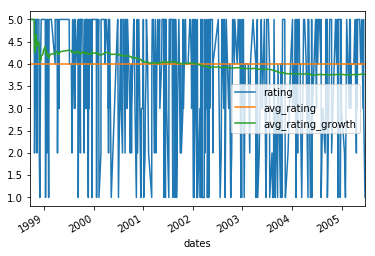

In [12]:
df = pd.DataFrame(data=answer_c, columns=['dates', 'rating', 'avg_rating'])
df['avg_rating_growth'] = means_array
df['dates'] = pd.to_datetime(df['dates'],infer_datetime_format=True)
df.plot(x='dates', y=['rating', 'avg_rating', 'avg_rating_growth'])
print(df)

## Questão D

### Listar os 10 produtos lideres de venda em cada grupo de produto

In [13]:
def emitByGroupNew(doc):
    obj = parse(doc)
    try:
        group = obj['GROUP']
        salesrank = obj['SALESRANK']
        product_id = obj['ID']
        title = obj['TITLE']
        return ( group, ( int(salesrank), title ) )
    except Exception as e:
        return ( -1, (-1, -1, -1) )
    
KEY = 0
VALUE = 1
SALESRANK = 0
TITLE = 1
    
rdd_d = data.map( emitByGroupNew ) \
            .filter( lambda x: x[VALUE][SALESRANK] != -1 ) \
            .sortBy( lambda x: x[VALUE][SALESRANK], ascending=True ) \
            .groupByKey() \
            .map( lambda x: ( x[KEY], list(x[VALUE])))

answer_d = rdd_d.collect()

In [14]:
for group in answer_d:
    print(bcolors.BOLD + '>>> Group: ' + str(group[0]) + bcolors.ENDC)
    count = 0
    for el in group[1]:
        print(bcolors.OKGREEN + '\tSalesrank: ' + str( el[0] ) + bcolors.ENDC + '\t' + el[1] )
        count = count + 1
        if(count == 10):
            break

>>> Group: Video
	Salesrank: 0	From Soup to Nuts
	Salesrank: 1	The War of the Worlds
	Salesrank: 2	Shirley Valentine
	Salesrank: 6	Leslie Sansone - Walk Away the Pounds - Super Fat Burning
	Salesrank: 7	Robin Hood - Men in Tights
	Salesrank: 8	Richard Simmons - Sweatin' to the Oldies
	Salesrank: 12	Howard the Duck
	Salesrank: 14	Charlotte's Web
	Salesrank: 16	A Tree Grows in Brooklyn
	Salesrank: 17	My Neighbor Totoro
>>> Group: Music
	Salesrank: 0	Improvisations - Jazz In Paris
	Salesrank: 0	Lucky Man
	Salesrank: 0	I Need Your Loving
	Salesrank: 0	That Travelin' Two-Beat/Sings the Great Country Hits
	Salesrank: 27	Buzz Buzz
	Salesrank: 33	A Rush of Blood to the Head
	Salesrank: 42	Michael Bublé
	Salesrank: 46	Come Away with Me
	Salesrank: 53	Songs About Jane
	Salesrank: 55	Facing Future
>>> Group: Sports
	Salesrank: 4684	Yoga Kit Living Arts
>>> Group: DVD
	Salesrank: 0	The Drifter
	Salesrank: 0	The House Of Morecock
	Salesrank: 0	1, 2, 3 Soleils: Taha, Khaled, Faudel
	Salesrank: 28	St

## Questão E

### Listar os 10 produtos com a maior média de avaliações úteis positivas

In [15]:
POSITIVE_RATING = 5

def getPositiveReviewsByIdNew(doc):
    try:
        obj = parse(doc)
        array = []
        title = obj['TITLE']
        product_id = obj['ID']
        for review in obj['REVIEWS']['reviews']:
            helpful = review['helpful']
            rating = int(review['rating'])
            if rating >= POSITIVE_RATING:
                array.append( ( int(product_id), ( int(helpful), 1, title ) ) )
        return array
    except Exception as e:
        return [ ( -1, (-1,-1,-1) ) ]

KEY = 0
VALUE = 1

HELPFUL = 0
COUNTER = 1
TITLE = 2
HELPFUL_AVERAGE = 0

# Already filter in-map
rdd_e = data.flatMap(getPositiveReviewsByIdNew) \
            .filter(lambda x: x[KEY] != -1 ) \
            .reduceByKey(lambda x, y: (x[HELPFUL] + y[HELPFUL], x[COUNTER] + y[COUNTER], x[TITLE])) \
            .map(lambda x: (x[VALUE][HELPFUL]/x[VALUE][COUNTER], x[VALUE][TITLE])) \
            .sortBy(lambda x: x[HELPFUL_AVERAGE], ascending=False) \

answer_e = rdd_e.take(10)

In [16]:
df = pd.DataFrame(data=answer_e, columns=['Helpful', 'Title'])
df

,Helpful,Title
0,320,Easy Adult Piano Beginner's Course
1,247,Small Engine Repair Up to 20 Hp
2,233,T'ai Chi for Older Adults
3,231,The Story About Ping (8x 8)
4,231,"The Story about Ping : StoryTape (StoryTape, P..."
5,231,The Story about Ping
6,231,The Story About Ping
7,206,The Glucose Revolution Pocket Guide to the Top...
8,203,More Than Just Hot Air: Common Sense Counter-T...
9,197,Crockpot Cookery (Cookbooks By Morris Press)


## Questão F

### Listar as 5 categorias de produto com a maior média de avaliações úteis positivas por produto

In [17]:
# WITH OBJECT
POSITIVE_RATING = 5

def getPositiveReviewsByCategory(doc):
    obj = parse(doc)
    array = []
    try:
        review_array = [ ( int(r['helpful']), 1) for r in obj['REVIEWS']['reviews'] if int(r['rating']) >= POSITIVE_RATING ]
        for el in obj['CATEGORIES']['categories']:
            for review in review_array:
                array.append( ( el, review ) )
        return array
    except Exception as e:
        return array

KEY = 0
VALUE = 1

HELPFUL = 0
COUNTER = 1
    
# In map filter
rdd_f = data.flatMap( getPositiveReviewsByCategory ) \
            .reduceByKey(lambda x, y: ( x[HELPFUL] + y[HELPFUL], x[COUNTER] + y[COUNTER] ) ) \
            .mapValues(lambda x: ( x[HELPFUL]/x[COUNTER] ) ) \
            .sortBy(lambda x: x[VALUE], ascending=False)

answer_f = rdd_f.take(5)

In [18]:
df = pd.DataFrame(data=answer_f, columns=['Title', 'Rating mean'] )
df

,Title,Rating mean
0,Dominican Republic[4816],97
1,Casual Users[502030],84
2,Casual Users[727732],84
3,Adventures of Ozzie and Harriet[13744851],80
4,Jack Benny Program[13744881],80


## Questão G

### Listar os 10 clientes que mais fizeram comentários por grupo de produtos

In [19]:
def getCustomerReviewsByGroup(doc):
    obj = parse(doc)
    array = []
    try:
        for review in obj['REVIEWS']['reviews']:
            array.append( ( ( obj['GROUP'], review['customer'] ) , 1  ) )
        return array
    except Exception as e:
        return array
    
KEY   = 0
VALUE = 1

GROUP = 0
CUSTOMER = 1
COUNT = 1

rdd_g = data.flatMap( getCustomerReviewsByGroup ) \
            .reduceByKey( lambda x,y: x + y ) \
            .map( lambda x: ( x[KEY][GROUP], ( x[KEY][CUSTOMER], x[VALUE] ) ) ) \
            .sortBy( lambda x: ( x[KEY], x[VALUE][COUNT] ), ascending = False ) \
            .groupByKey() \
            .map( lambda x: (x[0], list(x[1])))

answer_g = rdd_g.collect()

In [20]:
for group_tuple in answer_g:
    count = 0
    print(bcolors.BOLD + '>> Group: ' + group_tuple[0] + bcolors.ENDC)
    for customer in group_tuple[1]:
        print('\t\t ' + customer[0] + '\t' + bcolors.OKGREEN + str(customer[1]) + bcolors.ENDC)
        count = count + 1
        if(count == 10):
            break

>> Group: Video
		 ATVPDKIKX0DER	72581
		 A3UN6WX5RRO2AG	15814
		 A2NJO6YE954DBH	1775
		 AU8552YCOO5QX	1205
		 A3P1A63Q8L32C5	737
		 A20EEWWSFMZ1PN	720
		 A16CZRQL23NOIW	668
		 A3LZGLA88K0LA0	614
		 A2QRB6L1MCJ53G	606
		 A152C8GYY25HAH	583
>> Group: Music
		 ATVPDKIKX0DER	166149
		 A3UN6WX5RRO2AG	15875
		 A9Q28YTLYREO7	2760
		 A2U49LUUY4IKQQ	1258
		 A1GN8UJIZLCA59	1154
		 A2NJO6YE954DBH	1128
		 A1J5KCZC8CMW9I	1031
		 A3MOF5KF93Q6WE	989
		 AXFI7TAWD6H6X	814
		 A38U2M9OAEJAXJ	780
>> Group: Sports
		 A1W180Y9O1FALI	1
		 A18ZVYTEDAOF9A	1
		 A3O8EZOX2P399L	1
		 AL62LOJKDES3M	1
		 A2RHSQZ7MAKKCO	1
>> Group: DVD
		 ATVPDKIKX0DER	63148
		 A3UN6WX5RRO2AG	15549
		 A2NJO6YE954DBH	1366
		 AU8552YCOO5QX	1213
		 A3P1A63Q8L32C5	859
		 A3LZGLA88K0LA0	856
		 A82LIVYSX6WZ9	683
		 A152C8GYY25HAH	675
		 A16CZRQL23NOIW	651
		 A1CZICCYP2M5PX	650
>> Group: Video Games
		 A226EDS7WDF7S1	1
		 A3C811U31YG6FS	1
		 A1M4NJYP0WNL8Q	1
>> Group: Book
		 ATVPDKIKX0DER	643185
		 A3UN6WX5RRO2AG	154531
		 A14OJS0VWMOSWO	